In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
from datetime import timedelta 

from textblob import TextBlob

from scipy.stats import pearsonr

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100) # To see more of the headline text
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported for Task 3.")

Libraries imported for Task 3.


In [3]:

news_file_path = '../data/raw_analyst_ratings.csv' 

try:
    df_news = pd.read_csv(news_file_path)
    print(f"News data loaded successfully. Shape: {df_news.shape}")
    display(df_news.head(3))

    required_news_cols = ['headline', 'date', 'stock']
    if not all(col in df_news.columns for col in required_news_cols):
        missing_cols = [col for col in required_news_cols if col not in df_news.columns]
        print(f"Error: Missing required news columns: {missing_cols}. Please check column names.")
        # Stop or handle appropriately if critical columns are missing
        df_news = pd.DataFrame() # Invalidate df_news if critical cols are missing

    if not df_news.empty:
        # 2. Handle 'date' column: Convert to datetime, handle timezone (UTC-4)
        # The challenge states UTC-4. We should parse it and convert to UTC for consistency.
        print("\nProcessing 'date' column...")
        original_dates_sample = df_news['date'].head(3).copy()
        try:
            # Attempt to parse, inferring format. If UTC-4 is not explicitly in the string,
            # pandas might make it naive.
            df_news['parsed_date'] = pd.to_datetime(df_news['date'], errors='coerce')

            # Check if timezone info was parsed or needs to be set
            if df_news['parsed_date'].dt.tz is None:
                print("Date column parsed as timezone-naive. Localizing to UTC-4 (Etc/GMT+4) then converting to UTC.")
                # Etc/GMT+4 is the Olson timezone name for UTC-4
                df_news['parsed_date'] = df_news['parsed_date'].dt.tz_localize('Etc/GMT+4', ambiguous='infer')
                df_news['parsed_date_utc'] = df_news['parsed_date'].dt.tz_convert('UTC')
            else:
                print(f"Date column parsed with timezone: {df_news['parsed_date'].dt.tz}. Converting to UTC.")
                df_news['parsed_date_utc'] = df_news['parsed_date'].dt.tz_convert('UTC')

            # Extract just the date part for daily alignment later
            df_news['effective_date_utc'] = df_news['parsed_date_utc'].dt.date

            print("Date processing sample:")
            display(df_news[['date', 'parsed_date', 'parsed_date_utc', 'effective_date_utc']].head(3))

            # Check for parsing errors
            nat_count = df_news['parsed_date_utc'].isnull().sum()
            if nat_count > 0:
                print(f"Warning: {nat_count} date strings could not be parsed and resulted in NaT.")

        except Exception as e:
            print(f"Error processing date column: {e}")
            # If date processing fails, we might not be able to proceed effectively
            df_news['parsed_date_utc'] = pd.NaT
            df_news['effective_date_utc'] = pd.NaT


        # 3. Clean 'stock' tickers (e.g., uppercase, strip whitespace)
        df_news['stock'] = df_news['stock'].astype(str).str.upper().str.strip()
        df_news.dropna(subset=['headline', 'parsed_date_utc', 'stock'], inplace=True) # Drop rows where essential info is missing
        df_news = df_news[df_news['stock'] != 'NAN'] # Remove potential 'NAN' string tickers
        print(f"\nCleaned news data shape: {df_news.shape}")


except FileNotFoundError:
    print(f"Error: News data file not found at {news_file_path}")
    df_news = pd.DataFrame()
except Exception as e:
    print(f"An error occurred loading news data: {e}")
    df_news = pd.DataFrame()

News data loaded successfully. Shape: (1407328, 6)


,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/stocks-that-hit-52-week-highs-on-friday,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/stocks-that-hit-52-week-highs-on-wednesday,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/71-biggest-movers-from-friday,Lisa Levin,2020-05-26 04:30:07-04:00,A



Processing 'date' column...
Date column parsed with timezone: UTC-04:00. Converting to UTC.
Date processing sample:


,date,parsed_date,parsed_date_utc,effective_date_utc
0,2020-06-05 10:30:54-04:00,2020-06-05 10:30:54-04:00,2020-06-05 14:30:54+00:00,2020-06-05
1,2020-06-03 10:45:20-04:00,2020-06-03 10:45:20-04:00,2020-06-03 14:45:20+00:00,2020-06-03
2,2020-05-26 04:30:07-04:00,2020-05-26 04:30:07-04:00,2020-05-26 08:30:07+00:00,2020-05-26



Cleaned news data shape: (55977, 9)



Performing sentiment analysis on headlines using TextBlob...
Sentiment analysis complete. Sample with polarity scores:


,headline,sentiment_polarity
0,Stocks That Hit 52-Week Highs On Friday,0.0
1,Stocks That Hit 52-Week Highs On Wednesday,0.0
2,71 Biggest Movers From Friday,0.0
3,46 Stocks Moving In Friday's Mid-Day Session,0.0
4,"B of A Securities Maintains Neutral on Agilent Technologies, Raises Price Target to $88",0.0


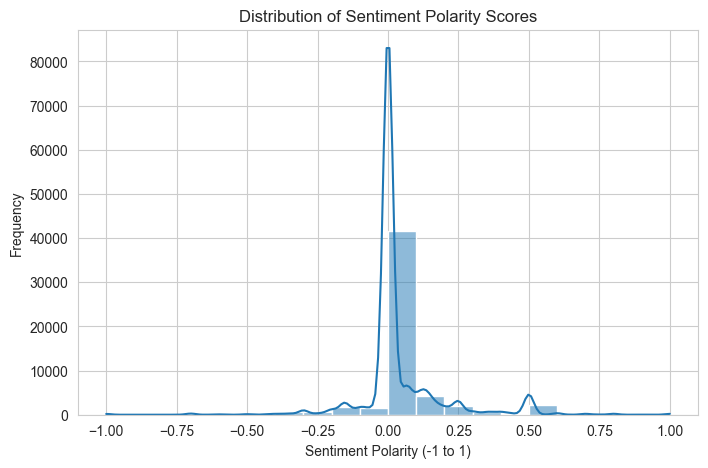

In [4]:

if not df_news.empty:
    print("\nPerforming sentiment analysis on headlines using TextBlob...")

    def get_sentiment_polarity(text):
        try:
            return TextBlob(str(text)).sentiment.polarity
        except:
            return 0 # Neutral for any error or non-string input

    # Apply to the 'headline' column
    # Ensure 'headline' is string type
    df_news['headline'] = df_news['headline'].astype(str)
    df_news['sentiment_polarity'] = df_news['headline'].apply(get_sentiment_polarity)

    print("Sentiment analysis complete. Sample with polarity scores:")
    display(df_news[['headline', 'sentiment_polarity']].head())

    # Display distribution of sentiment scores
    plt.figure(figsize=(8,5))
    sns.histplot(df_news['sentiment_polarity'], bins=20, kde=True)
    plt.title('Distribution of Sentiment Polarity Scores')
    plt.xlabel('Sentiment Polarity (-1 to 1)')
    plt.ylabel('Frequency')
    plt.show()
else:
    print("News DataFrame is empty. Skipping sentiment analysis.")


In [5]:
stock_data_dir = '../data/yfinance_data/' # Directory where your stock CSVs are stored

def load_stock_data_and_returns(ticker_symbol, filename_suffix='_historical_data.csv'):
    """
    Loads stock data for a given ticker, sets Date as index,
    and calculates daily returns.
    Adjusts filename based on how they were saved.
    """
    actual_filename = f'{ticker_symbol.upper()}{filename_suffix}'
    file_path = os.path.join(stock_data_dir, actual_filename)
    
    try:
        stock_df = pd.read_csv(file_path)
        stock_df['Date'] = pd.to_datetime(stock_df['Date'])
        stock_df.set_index('Date', inplace=True)
        
        # Calculate daily returns based on 'Close' or 'Adj Close'
        # Using 'Adj Close' is generally preferred as it accounts for dividends and splits
        price_column = 'Adj Close' if 'Adj Close' in stock_df.columns else 'Close'
        stock_df['daily_return'] = stock_df[price_column].pct_change()
        
        # Select only necessary columns to reduce memory
        stock_df = stock_df[['daily_return']].copy()
        stock_df.dropna(inplace=True) # Remove first NaN from pct_change
        return stock_df
    except FileNotFoundError:
        # print(f"Warning: Stock data file not found for {ticker_symbol} at {file_path}")
        return None
    except Exception as e:
        # print(f"Warning: Error loading stock data for {ticker_symbol}: {e}")
        return None

example_ticker_for_test = 'MSFT' # Or 'GOOG', 'NVDA', etc.
test_stock_returns_df = load_stock_data_and_returns(example_ticker_for_test)

if test_stock_returns_df is not None:
    print(f"Successfully loaded returns for {example_ticker_for_test}:")
    display(test_stock_returns_df.head())
else:
    print(f"Failed to load returns for {example_ticker_for_test}. Check filename/path and data.")

Successfully loaded returns for MSFT:


,daily_return
Date,
1986-03-14,0.035713
1986-03-17,0.017250
1986-03-18,-0.025432
1986-03-19,-0.017390
1986-03-20,-0.026547


In [11]:
# In notebooks/03_Sentiment_Correlation.ipynb

if not df_news.empty:
    print("\nStarting date alignment and sentiment aggregation...")
    
    # Define market hours in UTC (approximation)
    MARKET_OPEN_UTC_HOUR = 13 
    MARKET_CLOSE_UTC_HOUR = 20

    all_correlated_data = []
    unique_stocks_in_news = df_news['stock'].unique()
    print(f"Found {len(unique_stocks_in_news)} unique stocks in the news data to process.")

    processed_count = 0
    for stock_ticker in unique_stocks_in_news:
        processed_count += 1
        if processed_count % 100 == 0 or processed_count == len(unique_stocks_in_news): # Print progress
             print(f"Processing stock {processed_count}/{len(unique_stocks_in_news)}: {stock_ticker}")

        # 1. Get news for the current stock
        stock_specific_news = df_news[df_news['stock'] == stock_ticker].copy()
        if stock_specific_news.empty:
            continue

        # 2. Load stock returns for this ticker
        df_stock_returns = load_stock_data_and_returns(stock_ticker) # From Cell 4
        if df_stock_returns is None or df_stock_returns.empty:
            continue
            
        # Ensure the index of df_stock_returns is of type datetime.date
        df_stock_returns.index = pd.to_datetime(df_stock_returns.index).date


        # 3. Determine effective trading date for each news item
        # Ensure 'parsed_date_utc' is datetime before using .dt accessor
        stock_specific_news['parsed_date_utc'] = pd.to_datetime(stock_specific_news['parsed_date_utc'])
        
        def get_effective_trading_date(news_datetime_utc):
            news_date = news_datetime_utc.date()
            news_hour_utc = news_datetime_utc.hour

            if news_datetime_utc.dayofweek >= 5: # Saturday or Sunday
                days_to_monday = (7 - news_datetime_utc.dayofweek)
                return news_date + timedelta(days=days_to_monday)

            if news_hour_utc < MARKET_OPEN_UTC_HOUR: 
                return news_date
            elif MARKET_OPEN_UTC_HOUR <= news_hour_utc < MARKET_CLOSE_UTC_HOUR: 
                return news_date
            else: # After market close
                next_day = news_date + timedelta(days=1)
                if next_day.weekday() == 5: return next_day + timedelta(days=2) # Saturday -> Monday
                elif next_day.weekday() == 6: return next_day + timedelta(days=1) # Sunday -> Monday
                else: return next_day 

        stock_specific_news['trading_date_impact'] = stock_specific_news['parsed_date_utc'].apply(get_effective_trading_date)
        
        # 4. Aggregate sentiment per stock per trading_date_impact
        daily_sentiment = stock_specific_news.groupby('trading_date_impact')['sentiment_polarity'].mean().reset_index()
        daily_sentiment.rename(columns={'sentiment_polarity': 'avg_sentiment_polarity', 
                                        'trading_date_impact': 'Date'}, inplace=True)

        # Ensure 'Date' column in daily_sentiment is of type datetime.date
        daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date']).dt.date

        # 5. Merge aggregated sentiment with stock returns
        merged_df = pd.merge(
            df_stock_returns,      # Left DataFrame, uses its index for merging
            daily_sentiment,       # Right DataFrame, uses its 'Date' column for merging
            left_index=True,       # Join on the index of the left DataFrame (which is datetime.date)
            right_on='Date',       # Join on the 'Date' column of the right DataFrame (which is datetime.date)
            how='inner'
        )
        
        # 'Date' column from daily_sentiment is now in merged_df.
        # No need to set_index('Date') here if we want 'Date' as a column for Cell 6 sorting.
        
        if not merged_df.empty:
            merged_df['stock'] = stock_ticker # Add stock ticker for later analysis
            all_correlated_data.append(merged_df)

    if all_correlated_data:
        final_df = pd.concat(all_correlated_data)
        # Ensure 'Date' column is consistently datetime after concat if it was an index before
        if 'Date' not in final_df.columns and final_df.index.name == 'Date':
             final_df.reset_index(inplace=True)
        
        # Convert 'Date' column to datetime objects if it's not already (e.g. if it became object after concat)
        final_df['Date'] = pd.to_datetime(final_df['Date'])

        print("\nSample of final merged data with sentiment and returns:")
        display(final_df.head())
        print(f"Total rows in final_df: {len(final_df)}")
    else:
        print("\nNo correlated data could be generated. Check data alignment and availability.")
        final_df = pd.DataFrame() 

else:
    print("News DataFrame (df_news) is empty. Cannot proceed with alignment and aggregation.")
    final_df = pd.DataFrame() # Ensure final_df exists even if empty


Starting date alignment and sentiment aggregation...
Found 6203 unique stocks in the news data to process.
Processing stock 100/6203: ADT
Processing stock 200/6203: ALB
Processing stock 300/6203: ANTM
Processing stock 400/6203: AT
Processing stock 500/6203: BAB
Processing stock 600/6203: BGT
Processing stock 700/6203: BONE
Processing stock 800/6203: BX
Processing stock 900/6203: CCL
Processing stock 1000/6203: CHMT
Processing stock 1100/6203: CMRX
Processing stock 1200/6203: CRAI
Processing stock 1300/6203: CVA
Processing stock 1400/6203: DCA
Processing stock 1500/6203: DMO
Processing stock 1600/6203: DXJF
Processing stock 1700/6203: EGRW
Processing stock 1800/6203: EOPN
Processing stock 1900/6203: EVHC
Processing stock 2000/6203: FCB
Processing stock 2100/6203: FLIC
Processing stock 2200/6203: FSGI
Processing stock 2300/6203: GCC
Processing stock 2400/6203: GMK
Processing stock 2500/6203: GUT
Processing stock 2600/6203: HGT
Processing stock 2700/6203: HTR
Processing stock 2800/6203: 

,daily_return,Date,avg_sentiment_polarity,stock
0,-0.016848,2020-06-04,0.000000,GOOG
1,0.018560,2020-06-05,-0.051852,GOOG
2,0.005715,2020-06-08,0.139394,GOOG
3,0.006602,2020-06-09,0.066667,GOOG
4,0.006655,2020-06-10,0.011111,GOOG


Total rows in final_df: 12



--- Correlation Analysis ---
Overall Pearson Correlation between Avg Sentiment Polarity and Daily Return:
  Correlation: -0.1736
  P-value: 0.5895


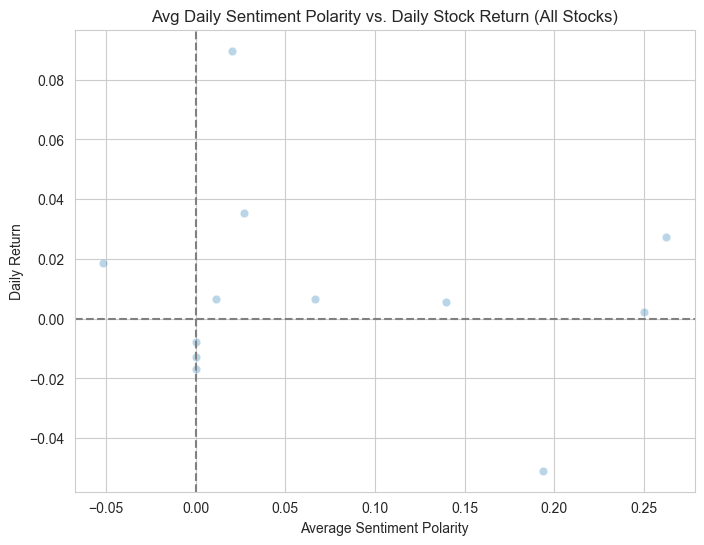


--- Lagged Correlation Analysis ---
Lagged Pearson Correlation (Sentiment Today vs. Next Day's Return):
  Correlation: 0.1369
  P-value: 0.7255


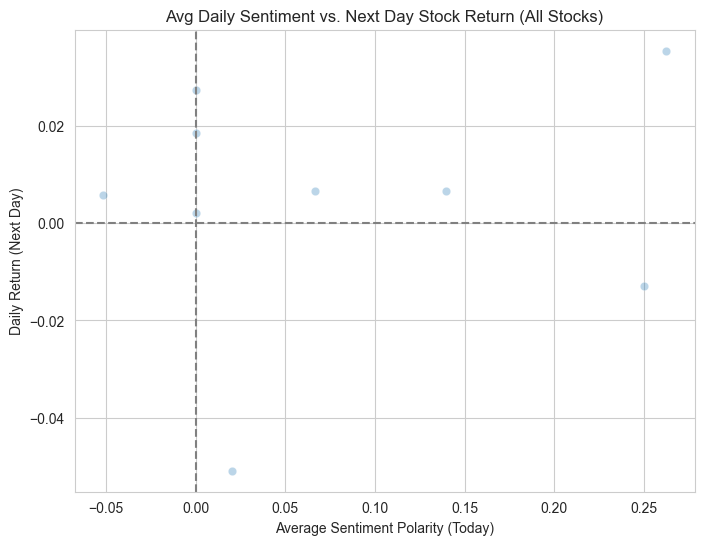

In [13]:

if not final_df.empty and 'avg_sentiment_polarity' in final_df.columns and 'daily_return' in final_df.columns and 'Date' in final_df.columns:
    print("\n--- Correlation Analysis ---")

    # Ensure 'Date' is datetime for proper sorting
    final_df['Date'] = pd.to_datetime(final_df['Date'])

    # Overall Correlation
    # Drop NaNs that might exist if sentiment or return is NaN for some reason
    correlation_subset_overall = final_df[['avg_sentiment_polarity', 'daily_return']].dropna()
    if len(correlation_subset_overall) > 1: # Need at least 2 data points
        overall_corr, overall_p_value = pearsonr(
            correlation_subset_overall['avg_sentiment_polarity'], 
            correlation_subset_overall['daily_return']
        )
        print(f"Overall Pearson Correlation between Avg Sentiment Polarity and Daily Return:")
        print(f"  Correlation: {overall_corr:.4f}")
        print(f"  P-value: {overall_p_value:.4f}")
    else:
        print("Not enough data points for overall correlation after dropping NaNs.")


    # Plotting
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='avg_sentiment_polarity', y='daily_return', data=final_df, alpha=0.3) # Use original final_df for scatter
    plt.title('Avg Daily Sentiment Polarity vs. Daily Stock Return (All Stocks)')
    plt.xlabel('Average Sentiment Polarity')
    plt.ylabel('Daily Return')
    plt.grid(True)
    plt.axhline(0, color='grey', linestyle='--')
    plt.axvline(0, color='grey', linestyle='--')
    plt.show()

    print("\n--- Lagged Correlation Analysis ---")
    lagged_df = final_df.copy()
    
    lagged_df.sort_values(by=['stock', 'Date'], inplace=True) # 'Date' is a column
    
    lagged_df['next_day_return'] = lagged_df.groupby('stock')['daily_return'].shift(-1)
    
    correlation_subset_lagged = lagged_df[['avg_sentiment_polarity', 'next_day_return']].dropna()

    if len(correlation_subset_lagged) > 1: # Need at least 2 data points
        lagged_corr, lagged_p_value = pearsonr(
            correlation_subset_lagged['avg_sentiment_polarity'], 
            correlation_subset_lagged['next_day_return']
        )
        print(f"Lagged Pearson Correlation (Sentiment Today vs. Next Day's Return):")
        print(f"  Correlation: {lagged_corr:.4f}")
        print(f"  P-value: {lagged_p_value:.4f}")

        plt.figure(figsize=(8, 6))
        sns.scatterplot(x='avg_sentiment_polarity', y='next_day_return', data=correlation_subset_lagged, alpha=0.3)
        plt.title('Avg Daily Sentiment vs. Next Day Stock Return (All Stocks)')
        plt.xlabel('Average Sentiment Polarity (Today)')
        plt.ylabel('Daily Return (Next Day)')
        plt.grid(True)
        plt.axhline(0, color='grey', linestyle='--')
        plt.axvline(0, color='grey', linestyle='--')
        plt.show()
    else:
        print("Not enough data for lagged correlation analysis after shifting and dropping NaNs.")
      
else:
    print("Final DataFrame is empty or missing required columns for correlation. Cannot perform correlation analysis.")